# About this notebook

This notebook is made for the 5-th week's assignment of the Coursera course "Applied Data Science Capstone," which is provided by IBM. This assignment is called "The Battle of Neighborhoods (Week 2)."

# Introduction

Zurich is one of the largest cities in Switzerland. These days, Japanese food such as Sushi can be easily found in the supermarkets of Zurich even though this city is located in the middle part of Europe. This fact implies that the potential interest of people in Japanese cuisine has been increasing. Considering this fact, opening a new Japanese restaurant in Zurich would be a good idea. However, there are already some Japanese restaurants in Zurich. Therefore, it is important, especially for people who are interested in opening a new Japanese restaurant in Zurich, to know which district is less crowded with Japanese restaurants. In addition, they should also know in which district there are many train stations because a lot of people who are potential customers come to stations every day. In this capstone project, I will show which district of Zurich is the best for opening a new Japanese restaurant in terms of the numbers of Japanese restaurants and train stations.

# Data

## Import modules.

In [13]:
import numpy as np
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import os
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from shapely.geometry import shape, Point

## Preparation of data

- **The names and coordinates of Japanese restaurants are imported using Foursquare.**
- **Based on the coordinates, a district, which is called "Kreis," is assigned to each restaurant. In order to do the assignment of restaurants, the geojson data of districts are obtained from the web page of Open Data Katalog provided by Stadt Zurich (https://data.stadt-zuerich.ch/dataset?sort=score+desc%2C+date_last_modified+desc&tags=geodaten&q=+Postleitzahl+zurich).**
- **The list of train stations of Zurich including their coordinates is taken from Wikipedia (https://en.wikipedia.org/wiki/Category:Railway_stations_in_Zürich).**
- **The numbers of restaurants and stations are determined for each district. This data can be used for revealing which area is more competitive and good for transportation.**

---

At first, the following information will be specified:
- the number of districts in Zurich. These districts are called "Kreis."
- the coordinate of the Zurich main station, which is called Zurich Hauptbahnhof and often abbreviated as Zurich HB.

The number number of districts is 12 (24/02/2019)

In [14]:
#number of districts (Kreis)
num_kreis=12

The coordinate of the Zurich HB will be obtained from a Wikipedia page 

In [15]:
# Wikipedia page of Zurich HB   (24.02.2019)
wikipedia_link='https://en.wikipedia.org/wiki/Zürich_Hauptbahnhof'
wikipedia_page=requests.get(wikipedia_link) 

wikipedia_page.encoding = wikipedia_page.apparent_encoding
latitude_ZHB=float(wikipedia_page.text[wikipedia_page.text.find('wgCoordinates')+22:wikipedia_page.text.find('wgCoordinates')+37])
longitude_ZHB=float(wikipedia_page.text[wikipedia_page.text.find('wgCoordinates')+44:wikipedia_page.text.find('wgCoordinates')+59])

print('Latitude: {}. Longitude: {}.'.format(latitude_ZHB,longitude_ZHB))
#Expected output:  "Latitude: 47.377777777778. Longitude: 8.5402777777778."

Latitude: 47.377777777778. Longitude: 8.5402777777778.


We will see if the obtained coordinate is correct. If the coordinate is correct, a red round marker will appear on the center of the Zurich HB with a popup of "Zurich Hauptbahnhof."

In [16]:
map_Zurich = folium.Map(location=[latitude_ZHB, longitude_ZHB], zoom_start=17) # generate map centred around the Hauptbahnhof

folium.CircleMarker(
        [latitude_ZHB, longitude_ZHB],
        radius=8,
        color='red',
        fill = True,
        fill_color='red',
        popup='Zurich Hauptbahnhof',
        fill_opacity=0.6
    ).add_to(map_Zurich)

map_Zurich

We have succeeded in defining the coordinate of the Zurich HB. As a next step, information about Japanese restaurants in Zurich will be obtained using Foursquare. In order to use Foursquare, the client ID, client secret, and version should be specified.

In [17]:
CLIENT_ID = 'FoursquareID' # your Foursquare ID
CLIENT_SECRET = 'FoursquareSecret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Using Foursquare, URL including information about Japanese restaurants in Zurich will be created. The word "Japanese" will be used for the search query for this purpose. The limit number of Japanese restaurants returned by Foursquare API will be set as 100. The radius from the Zurich HB will be set to be 10 km. This radius is large enough to cover all districts of Zurich.

In [18]:
search_query = 'Japanese'

LIMIT = 100 # limit of number of Japanese restaurants returned by Foursquare API
radius = 10000 # define radius. This radius should be large enough to cover all districts of Zurich.
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_ZHB, 
    longitude_ZHB,
    search_query,
    radius, 
    LIMIT)

results = requests.get(url).json()

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

A dataframe including the name of a restaurant and the coordinates will be created:

In [20]:
venues = results['response']['groups'][0]['items']
Restaurant = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.neighborhood', 'venue.location.lat', 'venue.location.lng']
Restaurant =Restaurant.loc[:, filtered_columns]

# filter the category for each row
Restaurant['venue.categories'] = Restaurant.apply(get_category_type, axis=1)

# clean columns
Restaurant.columns = [col.split(".")[-1] for col in Restaurant.columns]

Restaurant.head()

,name,categories,neighborhood,lat,lng
0,Kokoro,Japanese Restaurant,Kreis 4,47.380680,8.526546
1,Ikoo,Japanese Restaurant,Kreis 4,47.375044,8.528807
2,Miki Ramen,Japanese Restaurant,NaN,47.375152,8.516653
3,Japan-Restaurant Bimi,Japanese Restaurant,NaN,47.363665,8.549325
4,Samurai,Japanese Restaurant,NaN,47.373747,8.527697


In [21]:
num_restaurant=Restaurant.shape[0]
print('{} restaurants were returned by Foursquare.'.format(num_restaurant))

50 restaurants were returned by Foursquare.


The name of the column "neighborhood" will be changed to "Kreis." This column will be used to show which district the restaurant belongs to.

In [22]:
# Change the name of the column
Restaurant = Restaurant.rename(columns={'neighborhood': 'Kreis'})

Since we would like to assign districts (Kreis) to the obtained restaurants, we need to get the geographic information about the boundaries of the districts. The geojson data for showing districts in Zurich was obtained here:  
https://data.stadt-zuerich.ch/dataset/5fd779b6-64b3-4320-baa2-40e4de59dfc6/resource/261666ee-2ca0-43cb-927c-0f610e96cea1/download/stadtkreise.json

In [24]:
currentdir=os.getcwd()
datapath=currentdir+'/kreis.geojson'
#https://data.stadt-zuerich.ch/dataset/5fd779b6-64b3-4320-baa2-40e4de59dfc6/resource/261666ee-2ca0-43cb-927c-0f610e96cea1/download/stadtkreise.json
f=open(datapath)
json_data=json.load(f)

Define a function for visualizing boundaries.

In [25]:
def boundary(base_map, geojson_path):
    base_map.choropleth(geo_data=geojson_path, 
                        line_color="black", 
                        line_weight=3, 
                        fill_color='white', 
                        fill_opacity=0.1, 
                        line_opacity=0.5)

Show a map of Zurich with boundary lines of districts.

In [26]:
# Map of Zurich using latitude and longitude values
map_Zurich = folium.Map(location=[latitude_ZHB, longitude_ZHB], zoom_start=11) # generate map centred around the Hauptbahnhof
boundary(base_map=map_Zurich, geojson_path=json_data)
map_Zurich

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Now, the boundaries of the districts are defined correctly.  

As a next step, two modifications will be made for the dataframe.
- A district (Kreis) will be assigned to each restaurant based on the coordinate of the restaurant. If the coordinate of the restaurant is out of all districts of Zurich, the corresponding data will be discarded. 
- For some reasons, a few Chinese restaurants are also included in the data frame. They will be omitted from the data frame. 

In [27]:
# Define a function for showing which districts the coordinate (lat and lon) belongs to. 
def belong(geo_json, lat, lon):
    point = Point(lon, lat)
    for feature in geo_json['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['kname'] 
    return None

In [28]:
#Assign district (Kreis)
num_omit=1
for j in np.linspace(0,num_restaurant-1,num_restaurant):
    lat=Restaurant['lat'][j]
    lon=Restaurant['lng'][j]

    Assignment_Kreis = belong(json_data, lat, lon)
    
    if Assignment_Kreis==None:
        if num_omit==1:
            omitrows=[j]
            num_omit=2
        else:
            omitrows.append(j)
    else:
        Assignment_Kreis=Assignment_Kreis.strip('Kreis ')

        Restaurant['Kreis'][j]=int(Assignment_Kreis)

    if Restaurant['categories'][j]=='Chinese Restaurant':
        if num_omit==1:
            omitrows=[j]
            num_omit=2
        else:
            omitrows.append(j)
            

# Omit rows with "None" and/or "Chinese restaurant"
omitrows=[int(nn) for nn in omitrows]
Restaurant.drop(omitrows, axis=0,inplace=True)

#sort data based on the Kreis
Restaurant.sort_values('Kreis',inplace=True)

#reset index
Restaurant.reset_index(inplace=True,drop=True)

Restaurant

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,categories,Kreis,lat,lng
0,O'Tabe,Japanese Restaurant,1,47.368881,8.538315
1,Negishi Sushi Bar,Sushi Restaurant,1,47.371517,8.535471
2,Sushishop,Sushi Restaurant,1,47.372857,8.535131
3,Takano City,Japanese Restaurant,1,47.374636,8.535804
4,Negishi Sushi Bar,Japanese Restaurant,1,47.370853,8.543192
5,Isakaya,Japanese Restaurant,1,47.376640,8.540564
6,Yooji's sushi deli,Sushi Restaurant,1,47.378033,8.538804
7,Sora Sushi,Sushi Restaurant,1,47.377623,8.539133
8,Barfüsser,Sushi Restaurant,1,47.373601,8.544591
9,Yooji's,Sushi Restaurant,1,47.367173,8.546464


In [29]:
print('{} restaurants in Zurich were found by Foursquare.'.format(Restaurant.shape[0]))

43 restaurants in Zurich were found by Foursquare.


The number of Japanese restaurants is summarized for each district.

In [30]:
df_kreis_restaurant=pd.DataFrame({ 'Kreis' : pd.Series(range(0,num_kreis+1,1),dtype='int'),
                                  'Number of restaurants' : 0})

for j1 in range(0,num_kreis+1,1):
    if (j1 in Restaurant['Kreis'].value_counts().index)==True:
        df_kreis_restaurant['Number of restaurants'][j1]=Restaurant['Kreis'].value_counts()[j1]

df_kreis_restaurant.drop([0], axis=0, inplace=True)
df_kreis_restaurant

,Kreis,Number of restaurants
1,1,13
2,2,3
3,3,3
4,4,7
5,5,6
6,6,1
7,7,0
8,8,4
9,9,2
10,10,1


- Now, the coordinates of stations in Zurich city will be obtained.

In [31]:
currentdir=os.getcwd()
datapath=currentdir+'/stations.kml'
myfile= open(datapath, 'r', encoding="utf-8")
coord_stations = myfile.readlines() 
myfile.close()

print(coord_stations)

['<?xml version="1.0" encoding="UTF-8"?>\n', '<kml xmlns="http://earth.google.com/kml/2.1">\n', '<Document>\n', '\t<name><![CDATA[Category:Railway stations in Zürich]]></name>\n', '\t<open>1</open>\n', '\t\t<Placemark>\n', '\t\t\t<name><![CDATA[Stettbach railway station]]></name>\n', '\t\t\t<Point>\n', '\t\t\t\t<coordinates>8.5961,47.3972,0</coordinates>\n', '\t\t\t</Point>\n', '\t\t\t<Snippet></Snippet>\n', '\t\t\t<description><![CDATA[<br>Source: Wikipedia article <a href="https://en.wikipedia.org/wiki/Stettbach_railway_station">Stettbach railway station</a>]]></description>\n', '\t\t</Placemark>\n', '\t\t<Placemark>\n', '\t\t\t<name><![CDATA[Zürich Affoltern railway station]]></name>\n', '\t\t\t<Point>\n', '\t\t\t\t<coordinates>8.508241,47.421014,0</coordinates>\n', '\t\t\t</Point>\n', '\t\t\t<Snippet></Snippet>\n', '\t\t\t<description><![CDATA[<br>Source: Wikipedia article <a href="https://en.wikipedia.org/wiki/Zürich_Affoltern_railway_station">Zürich Affoltern railway station</a>]

In [32]:
print('The obtained list consists of {} rows.'.format(len(coord_stations)))

The obtained list consists of 207 rows.


A new dataframe including the name of stations, their districts, and coordinates will be created and sorted based on the district (Kreis).

In [33]:
station_list=[]
station_lon=[]
station_lat=[]
Assignment_Kreis_stations=[]

for j in range(0,len(coord_stations),1):
    if (('<name><![CDATA[' in coord_stations[j])== True) and (5<j) and (j<len(coord_stations)-2):
        station_list.append(coord_stations[j][coord_stations[j].index('CDATA')+6:coord_stations[j].index(']]></name>')])
        
        lat=float(coord_stations[j+2][coord_stations[j+2].index(',')+1:coord_stations[j+2].index('</coordinates>')-2])
        lon=float(coord_stations[j+2][coord_stations[j+2].index('<coordinates>')+13:coord_stations[j+2].index(',')])
        station_lon.append(lon)
        station_lat.append(lat)
        Assignment_Kreis_stations.append(int(belong(json_data, lat, lon).strip('Kreis ')))
               
        
cols = ['station','Kreis','latitude','longitude']
df_stations = pd.DataFrame(index=[], columns=cols)
df_stations['station']=station_list
df_stations['Kreis']=Assignment_Kreis_stations
df_stations['latitude']=station_lat
df_stations['longitude']=station_lon



#sort data based on the Kreis
df_stations.sort_values('Kreis',inplace=True)

#reset index
df_stations.reset_index(inplace=True,drop=True)

df_stations

,station,Kreis,latitude,longitude
0,Zürich Stadelhofen railway station,1,47.366667,8.548611
1,Zürich Hauptbahnhof,1,47.377778,8.540278
2,Zürich Manegg railway station,2,47.338216,8.519881
3,Zürich Leimbach railway station,2,47.333600,8.519100
4,Zürich Enge railway station,2,47.365278,8.531944
5,Zürich Wollishofen railway station,2,47.347800,8.533800
6,Zürich Brunau railway station,2,47.351952,8.526496
7,Zürich Friesenberg railway station,3,47.364700,8.508000
8,Zürich Wiedikon railway station,3,47.371400,8.523600
9,Zürich Triemli railway station,3,47.365000,8.495200


The number of stations will be added to the dataframe "df_kreis_restaurant" including the number of restaurants.

In [34]:
numsta=[]
for j1 in range(1,num_kreis+1,1):
    if (j1 in df_stations['Kreis'].value_counts().index)==True:
        numsta.append(df_stations['Kreis'].value_counts()[j1])
    else:
        numsta.append(0)

df_kreis_restaurant['Number of stations']=numsta

df_kreis_restaurant

,Kreis,Number of restaurants,Number of stations
1,1,13,2
2,2,3,5
3,3,3,7
4,4,7,2
5,5,6,0
6,6,1,0
7,7,0,0
8,8,4,2
9,9,2,1
10,10,1,2


# Methodology

- The district (Kreis) where the number of Japanese restaurants is large is emphasized by a choropleth map in order to understand a crowded district visually. 
- More qualitative evaluation will be done by comparing bar charts of the number of Japanese resutaurants and that of stations.
- By taking the ratio of the number of Japanese restaurants and that of stations, the most ideal district is determined.

# Results and Discussion

The obtained data will be shown as a choropleth map. In the map, the position of the Japanese restaurants and stations in Zurich are also shown by blue and black circles, respectively.

In [40]:
map_Zurich = folium.Map(location=[latitude_ZHB, longitude_ZHB], zoom_start=12) # generate map centred around the Hauptbahnhof

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
map_Zurich.choropleth(
    geo_data=json_data,
    data=df_kreis_restaurant,
    columns=['Kreis','Number of restaurants'],
    key_on='feature.properties.knr',
    fill_color='YlOrRd', 
#    threshold_scale=[0.0,1.0,2.0,3.0,12.0],
    fill_opacity=0.5, 
    line_opacity=0.6,
    legend_name='Number of Japanese restaurants'
)

for lat, lng, label in zip(Restaurant.lat, Restaurant.lng, Restaurant.name):
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_Zurich)
    
for lat, lng, label in zip(df_stations.latitude, df_stations.longitude, df_stations.station):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='black',
        popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.5
    ).add_to(map_Zurich)

# display map
map_Zurich

As you can see, the central part (Kreis 1) is a very competitive area. This district is the one where the Zurich main station exist.

Next, the number of stations and Japanese restaurants will be shown as bar graphs.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<BarContainer object of 12 artists>

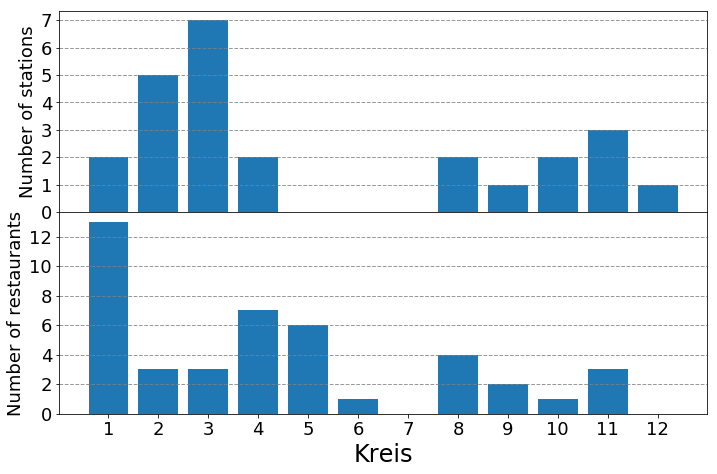

In [36]:
fig = plt.figure()

ax1 = fig.add_axes((0, 0.7, 1.5, 0.7))
ax2 = fig.add_axes((0, 0, 1.5, 0.7), sharex=ax1)

ax1.tick_params(labelbottom="off")
ax2.set_xticks(np.arange(1,13,1))
ax2.set_xlabel('Kreis',fontsize=24)
ax1.set_ylabel('Number of stations',fontsize=18)
ax2.set_ylabel('Number of restaurants',fontsize=18)

for tick in ax2.xaxis.get_ticklabels():
    tick.set_fontsize(18)
for tick in ax2.yaxis.get_ticklabels():
    tick.set_fontsize(18)
for tick in ax1.yaxis.get_ticklabels():
    tick.set_fontsize(18)
    

ax1.grid(which = "major", axis = "y", color = "grey", alpha = 0.8,linestyle = "--", linewidth = 1)
ax2.grid(which = "major", axis = "y", color = "grey", alpha = 0.8,linestyle = "--", linewidth = 1)


ax1.bar(np.linspace(1,12,12), df_kreis_restaurant['Number of stations'])
ax2.bar(np.linspace(1,12,12), df_kreis_restaurant['Number of restaurants'])

There are some notable features:  
- The numbe rof Japanese restaurants in Kreis 1 is large even though there are only 2 stations. However, it should be noted that there is the Zurich main station in this district.
- In Kreis 7, there are relatively many train stations. Compared to the number of stations, that of the Japanese restaurants is relatively small.
- There are no train stations in Kreis 5, 6, and 7.
- There are no Japanese restaurants in Kreis 7 and 12.

Now, we would like to find the district where the number of the restaurants is small and that of the stations is large. In order to consider both factors, the ratio R is defined by  
R=N<sub>sta</sub>/N<sub>res</sub>,  
where N<sub>sta</sub> is the number of stations and N<sub>res</sub> is the number of restaurants. The parameter R always satisfies 0<=R. If the ratio R is large, there are not so many Japanese restaurants, but relatively many stations in the corresponding district has not many. Hence, the district with a large R is an ideal area for opening a new Japanese restaurant in terms of good transportation and number of other Japanese restaurants.

In the case that N<sub>sta</sub> is not equal to 0 and N<sub>res</sub> equals 0, R becomes infinite. In this case, for the sake of simplicity, R is replaced by -0.5 so that you can easily distinguish such data. The parameter R is calculated as follows:

In [37]:
R=df_kreis_restaurant['Number of stations']/df_kreis_restaurant['Number of restaurants']
R=R.fillna(0)
R=R.replace(np.inf,np.nan).fillna(-0.5)
print(R)

1     0.153846
2     1.666667
3     2.333333
4     0.285714
5     0.000000
6     0.000000
7     0.000000
8     0.500000
9     0.500000
10    2.000000
11    1.000000
12   -0.500000
dtype: float64


The parameter R will be visualized.

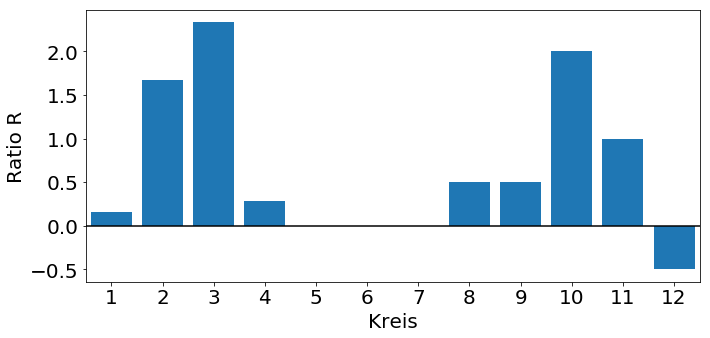

In [38]:
plt.figure(figsize=(11, 5))

plt.bar(x=np.arange(1,13,1),height=R)


plt.xlabel('Kreis',fontsize=20)
plt.ylabel('Ratio R',fontsize=20)

plt.tick_params(labelsize=20)

plt.hlines([0], -1, 13, "black", linestyles='solid')  

plt.xlim(0.5,12.5)
plt.xticks(np.arange(1,13,1))
plt.yticks(np.arange(-0.5,2.1,0.5))

plt.show()

From the figure shown above, you can learn:  
- Kreis 12 is less competitive. There are no Japanese restaurants, but there is at least one station.  
- Kreis 3 and Kreis 10 are also relatively good. The high R parameters show that there are many stations compared to the number of Japanese restaurants.
- Kreis 5, 6, and 7 are worst in terms of transportation because the R parameters have the value of 0.

# Conclusion

Possible districts for opening a new Japanese restaurant are Kreis 3,10, and 12. From the analysis, the following conclusions are derived. 

- Kreis 12 is less competitive. There are no Japanese restaurants, but there is one station.  
- Kreis 3 and Kreis 10 are also relatively good because the number of stations is relatively large compared to that of Japanese restaurants. 
- Kreis 5, 6, and 7 are worst in terms of transportation. In fact, there are no train stations.